<a href="https://colab.research.google.com/github/rudycav/RedditScraper/blob/edit/Project/r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install praw
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.8/188.8 KB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 KB 7.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [158]:
import praw
from praw.models import MoreComments
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
import re
import requests

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [176]:
reddit = praw.Reddit(
    client_id="",
    client_secret = "",
    password = "",
    user_agent = "",
    username = "",
    check_for_async=False
)

url='https://web-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'
for start in range(1, 100, 1000):
    params = {
        'start': start,
        'limit': 150,
            }
    r = requests.get(url, params=params)
    data = r.json()

ticker = [(crypto['symbol'].lower()) for crypto in (data['data'])]
slug = [(crypto['name'].lower()) for crypto in (data['data'])]



def reddit_scraper(reddit, subreddit_page, limit):
  df = pd.DataFrame()
  subreddit = reddit.subreddit(subreddit_page)
  hot_topic = subreddit.hot(limit=limit)

  for x in hot_topic: 
    c = x.comments.list()
    for y in c:
      if isinstance(y, MoreComments):
        continue
      df = df.append({'title': x.title,
                      #'author': y.author,
                      'comments': y.body,
                      #'upvote_score': y.score
                      },                                          
                      ignore_index=True) 

  return df

wall = reddit_scraper(reddit, 'CryptoCurrency', 50)

In [198]:
tokenizer = RegexpTokenizer(r'\w+')
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def text_cleaner(df):
    cleaned_text = []
    for text in df:
        tokenize_words = tokenizer.tokenize(text)      
        stop_word_filter = [token.lower() for token in tokenize_words if token.lower() not in stop_words and not token.isdigit()]
        lemmitize_words = ([lemmatizer.lemmatize(token) for token in stop_word_filter])
        cleaned_text.extend(lemmitize_words)
    
    return cleaned_text

def sentiment_analysis(df):
  return text_cleaner(df)

comments = text_cleaner(wall.comments)

sia = SIA()

ps = []
for comment in comments:
    score = sia.polarity_scores(comment)
    score['replies'] = comment
    ps.append(score)

pol_df = pd.DataFrame.from_records(ps)


pol_df['sentiment'] = 0
pol_df.loc[pol_df['compound'] > 0.3, 'sentiment'] = 1
pol_df.loc[pol_df['compound'] < -0.3, 'sentiment'] = -1


bullish = sentiment_analysis(pol_df[pol_df.sentiment==1].replies)
bearish = sentiment_analysis(pol_df[pol_df.sentiment==-1].replies)
neutral = sentiment_analysis(pol_df[pol_df.sentiment==0].replies)


df_bull_ticker = pd.DataFrame(Counter([crypto for bull in bullish for crypto in ticker if bull==crypto]).most_common(5), columns=['Name', 'Frequencies'])
df_bull_slug = pd.DataFrame(Counter([crypto for bull in bullish for crypto in slug if bull==crypto]).most_common(5), columns=['Name', 'Frequencies'])

df_bear_ticker = pd.DataFrame(Counter([crypto for bear in bearish for crypto in ticker if bear==crypto]).most_common(5), columns=['Name', 'Frequencies'])
df_bear_slug = pd.DataFrame(Counter([crypto for bear in bearish for crypto in slug if bear==crypto]).most_common(5), columns=['Name', 'Frequencies'])

df_neutral_ticker = pd.DataFrame(Counter([crypto for neu in neutral for crypto in ticker if neu==crypto]).most_common(5), columns=['Name', 'Frequencies'])
df_neutral_slug = pd.DataFrame(Counter([crypto for neu in neutral for crypto in slug if neu==crypto]).most_common(5), columns=['Name', 'Frequencies'])

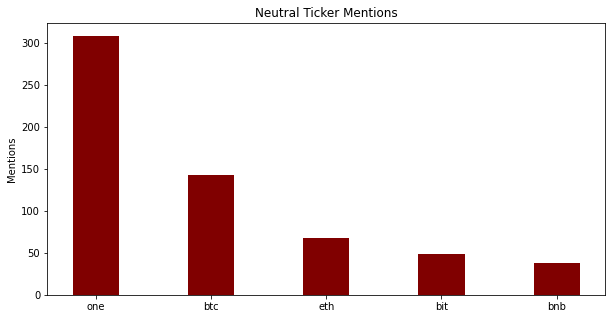

In [199]:
fig = plt.figure(figsize = (10, 5))
plt.bar(df_neutral_ticker.Name, df_neutral_ticker.Frequencies, color ='maroon',
        width = 0.4)
 
plt.ylabel("Mentions")
plt.title("Neutral Ticker Mentions")
plt.show()

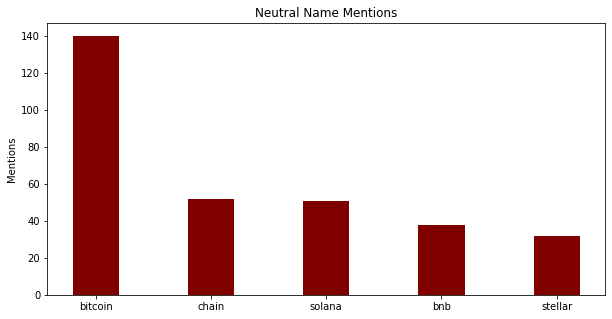

In [200]:
fig = plt.figure(figsize = (10, 5))
plt.bar(df_neutral_slug.Name, df_neutral_slug.Frequencies, color ='maroon',
        width = 0.4)
 

plt.ylabel("Mentions")
plt.title("Neutral Name Mentions")
plt.show()

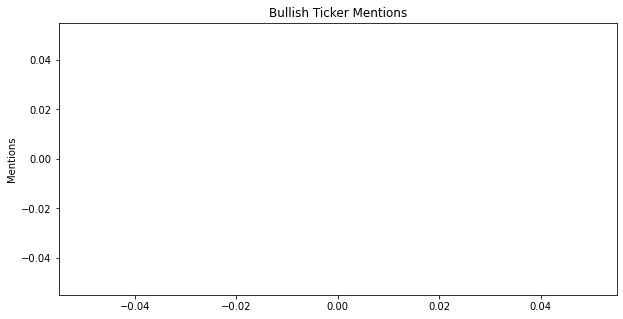

In [201]:
fig = plt.figure(figsize = (10, 5))
plt.bar(df_bull_ticker.Name, df_bull_ticker.Frequencies, color ='maroon',
        width = 0.4)
 

plt.ylabel("Mentions")
plt.title("Bullish Ticker Mentions")
plt.show()

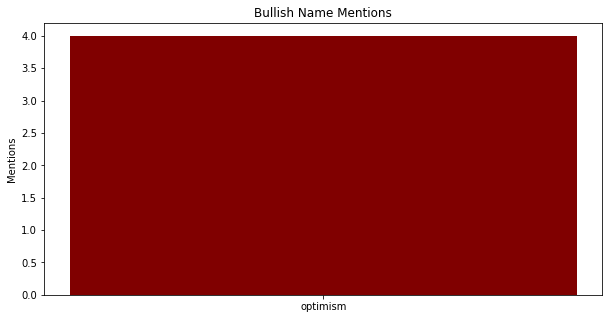

In [202]:
fig = plt.figure(figsize = (10, 5))
plt.bar(df_bull_slug.Name, df_bull_slug.Frequencies, color ='maroon',
        width = 0.4)
 

plt.ylabel("Mentions")
plt.title("Bullish Name Mentions")
plt.show()

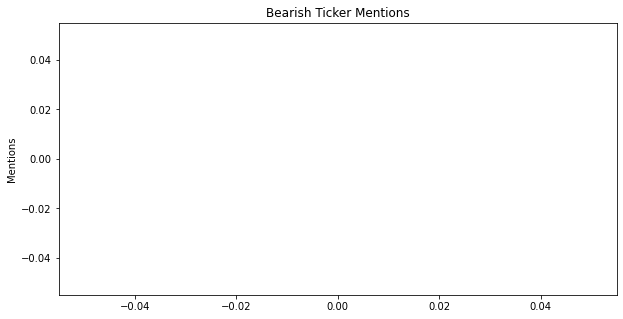

In [203]:
fig = plt.figure(figsize = (10, 5))
plt.bar(df_bear_ticker.Name, df_bear_ticker.Frequencies, color ='maroon',
        width = 0.4)
 

plt.ylabel("Mentions")
plt.title("Bearish Ticker Mentions")
plt.show()

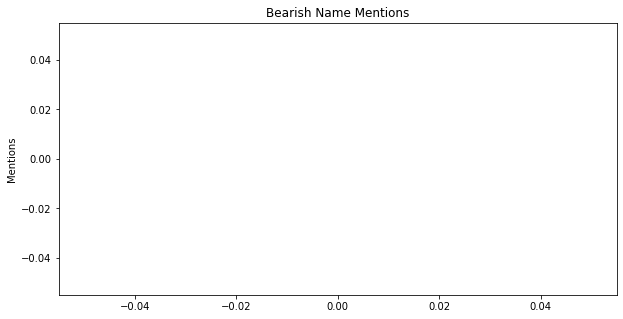

In [204]:
fig = plt.figure(figsize = (10, 5))
plt.bar(df_bear_slug.Name, df_bear_slug.Frequencies, color ='maroon',
        width = 0.4)
 

plt.ylabel("Mentions")
plt.title("Bearish Name Mentions")
plt.show()